In [2]:
import matplotlib.pyplot as plt
import functions
import numpy as np
import math, pyarrow.parquet as pq, os, glob
import pandas as pd

In [3]:
# def read_parquet_range(base_dir, subfolder, start_date=None, end_date=None):
#     """
#     Читает все parquet-файлы из поддиректории (ticks/orderbook) за указанный диапазон дат.
#     Если даты не указаны — читает все файлы.
#     """
#     pattern = os.path.join(
#         base_dir, subfolder, "year=*", "month=*", "day=*", "day=*.parquet"
#     )
#     files = glob.glob(pattern)
#     if not files:
#         raise FileNotFoundError(f"No files found in {pattern}")
    
#     dfs = []
#     for file in files:
#         fname = os.path.basename(file)
#         date_str = fname.replace("day=", "").replace(".parquet", "")
#         if start_date or end_date:
#             file_date = pd.to_datetime(date_str)
#             if start_date and file_date < pd.to_datetime(start_date):
#                 continue
#             if end_date and file_date > pd.to_datetime(end_date):
#                 continue
#         dfs.append(pd.read_parquet(file))
#     if dfs:
#         return pd.concat(dfs, ignore_index=True)
#     else:
#         return pd.DataFrame()

In [4]:

# Cell 2: читаем паркет один раз
df, odf = functions.read_files(
    '2025-07-12','2025-07-17'
)
odf['recv_time'] = pd.to_datetime(odf['recv_time'])


In [53]:
if 'recv_time' not in df.columns:
    df = df.reset_index()
    
# считаем индикаторы
PERIOD = '1h'
STEP   = 0.5
va_df      = functions.value_area(df.copy(), PERIOD, STEP)
delta      = functions.volume_delta(df.copy(), PERIOD).rename('volume_delta')
vpin       = functions.VPIN(df.copy(), PERIOD, functions.BUCKET_SIZE, functions.WINDOW_LENGTH)
ofi        = functions.process_order_flow_imbalance(odf, PERIOD)
rf         = functions.RF(va_df)
kyle_lambda= functions.vectorized_kyle_lambda(df.copy(), PERIOD)

price_bar = (
    df.set_index('recv_time')['price']
      .resample(PERIOD)
      .last()            # закрытие бара
      .ffill()           # если бар пустой — дублируем предыдущее значение
      .rename('price')
)

# 2) Объединяем с вашим indicators_df
indicators_df = pd.concat(
    [va_df, delta, vpin, rf, ofi, kyle_lambda], axis=1
).join(price_bar, how='left')

print(indicators_df[['price']].head(10))


                             price
2025-07-12 12:00:00  117427.500000
2025-07-12 13:00:00  117472.203125
2025-07-12 14:00:00  117341.898438
2025-07-12 15:00:00  117072.296875
2025-07-12 16:00:00  117152.500000
2025-07-12 17:00:00  117425.796875
2025-07-12 18:00:00  117464.898438
2025-07-12 19:00:00  117511.203125
2025-07-12 20:00:00  117206.101562
2025-07-12 21:00:00  117206.101562


подсчет сигналов и выбор timestamp

In [64]:
rf = indicators_df['RF']
vpin = indicators_df['VPIN']
ofi = indicators_df['OFI']
kl = indicators_df['Kyle_Lambda']
vol_del = indicators_df['volume_delta']
price = indicators_df['price']

'''-----------------------пересечение цены VAH или VAL-----------------------'''
P = indicators_df['price']
H = indicators_df['VAH']
L = indicators_df['VAL']

P_prev = P.shift(1)
H_prev = H.shift(1)
L_prev = L.shift(1)

indicators_df['VAH_sell']  = (P <  H) & (P_prev >= H_prev)

indicators_df['VAL_buy'] = (P >  L) & (P_prev <= L_prev)
'''--------------------------------------------------------------------------'''

'''-----------------------rotation factor-----------------------'''
rf_buy = rf < 0.5
rf_sell = rf > 2.0

indicators_df['rf_buy'] = rf_buy.fillna(False)
indicators_df['rf_sell'] = rf_sell.fillna(False)
'''--------------------------------------------------------------'''

'''-----------------------kyle's lambda-----------------------'''
kl_buy = kl < 0.05
kl_sell = kl > 0.2

indicators_df['kl_buy'] = kl_buy.fillna(False)
indicators_df['kl_sell'] = kl_sell.fillna(False)
'''--------------------------------------------------------------'''

'''-----------------------изменение ofi с отрицательного на положительное-----------------------'''
ofi_sw_pos = (indicators_df['OFI'] < 0) & (indicators_df['OFI'].shift(1) > 0) & (indicators_df['OFI'].shift(2) > indicators_df['OFI'].shift(1))
ofi_sw_neg = (indicators_df['OFI'] > 0) & (indicators_df['OFI'].shift(1) < 0) & (indicators_df['OFI'].shift(2) < indicators_df['OFI'].shift(1))

indicators_df['ofi_sw_pos'] = ofi_sw_pos.fillna(False)
indicators_df['ofi_sw_neg'] = ofi_sw_neg.fillna(False)
'''---------------------------------------------------------------------------------------------'''

'''-----------------------изменение volume delta с отрицательного на положительное-----------------------'''
vol_del_sw_pos = (indicators_df['volume_delta'] < 0) & (indicators_df['OFI'].shift(1) > 0) & (indicators_df['volume_delta'].shift(2) > indicators_df['volume_delta'].shift(1))
vol_del_sw_neg = (indicators_df['volume_delta'] > 0) & (indicators_df['OFI'].shift(1) < 0) & (indicators_df['volume_delta'].shift(2) < indicators_df['volume_delta'].shift(1))

indicators_df['vol_del_sw_pos'] = vol_del_sw_pos.fillna(False)
indicators_df['vol_del_sw_neg'] = vol_del_sw_neg.fillna(False)
'''------------------------------------------------------------------------------------------------------'''

open_pos_long = (
    # indicators_df['ofi_sw_pos'] & 
    # indicators_df['vol_del_sw_pos'] &
    # indicators_df['rf_buy'] &
    indicators_df['kl_buy']
    # & indicators_df['VAL_buy']
)

close_pos_long = (
    # indicators_df['ofi_sw_neg'] & 
    # indicators_df['vol_del_sw_neg'] &
    # indicators_df['rf_sell'] &
    indicators_df['kl_sell']
    # & indicators_df['VAH_sell']
)

open_pos_short = close_pos_long
close_pos_short = open_pos_long

#открытие и закрытие позиций
longs_open  = indicators_df.index[ open_pos_long.fillna(False) ].unique()
longs_close = indicators_df.index[ close_pos_long.fillna(False) ].unique()
print(longs_open, longs_close)

shorts_open  = longs_close
shorts_close = longs_open


DatetimeIndex(['2025-07-12 13:00:00', '2025-07-12 15:00:00',
               '2025-07-12 18:00:00', '2025-07-12 19:00:00',
               '2025-07-13 12:00:00', '2025-07-16 05:00:00',
               '2025-07-16 13:00:00', '2025-07-16 16:00:00',
               '2025-07-16 17:00:00'],
              dtype='datetime64[ns]', freq=None) DatetimeIndex(['2025-07-12 14:00:00', '2025-07-15 22:00:00',
               '2025-07-16 21:00:00', '2025-07-17 00:00:00'],
              dtype='datetime64[ns]', freq=None)


соотнесение временных меток с ценами и создания списков трейдов

In [65]:
# --- Подготовка ts/pr ---
ts = df['recv_time'].astype(np.int64).to_numpy()
pr = df['price'].to_numpy()

# --- Переводим времена в наносекунды для всех сигналов ---
events = {
    'long': {
        'open_idx': longs_open,
        'close_idx': longs_close,
    },
    'short': {
        'open_idx': shorts_open,
        'close_idx': shorts_close,
    }
}

# --- Интерполируем цены для каждого события ---
for direction, ev in events.items():
    ev['open_ns']  = ev['open_idx'].astype(np.int64)
    ev['close_ns'] = ev['close_idx'].astype(np.int64)
    ev['open_pr']  = np.interp(ev['open_ns'],  ts, pr)
    ev['close_pr'] = np.interp(ev['close_ns'], ts, pr)

# --- Матчим и собираем все трейды с признаком direction ---
trades = []
for direction, ev in events.items():
    opens, closes = ev['open_idx'], ev['close_idx']
    op_pr, cl_pr  = ev['open_pr'],  ev['close_pr']
    i = j = 0
    while i < len(opens) and j < len(closes):
        t_o, t_c = opens[i], closes[j]
        if t_c <= t_o:
            j += 1
            continue
        entry, exit_ = op_pr[i], cl_pr[j]
        profit = (exit_ - entry) if direction == 'long' else (entry - exit_)
        trades.append({
            'direction':   direction,
            'entry_time':  t_o,
            'exit_time':   t_c,
            'entry_price': entry,
            'exit_price':  exit_,
            'profit':      profit,
            # риск 1% депозита: если депо=10000, то position size ~ 10000*0.01/stop_loss
            'return':      profit / entry
        })
        i += 1
        j += 1


расчет доходности стратегии

In [66]:
price_ser    = df.set_index('recv_time')['price']
deposit = 10_000
risk = 0.01
equity = [deposit]
times  = [trades[0]['entry_time'] if trades else df['recv_time'].iloc[0]]
for tr in trades:
    ret = (tr['exit_price'] - tr['entry_price']) / tr['entry_price']
    pnl = equity[-1] * risk * ret
    equity.append(equity[-1] + pnl)
    times.append(tr['exit_time'])

# 5) Расчёт buy&hold
bh_price = price_ser
bh_equity = deposit * (bh_price / bh_price.iloc[0])

отрисовка точек входа на цене

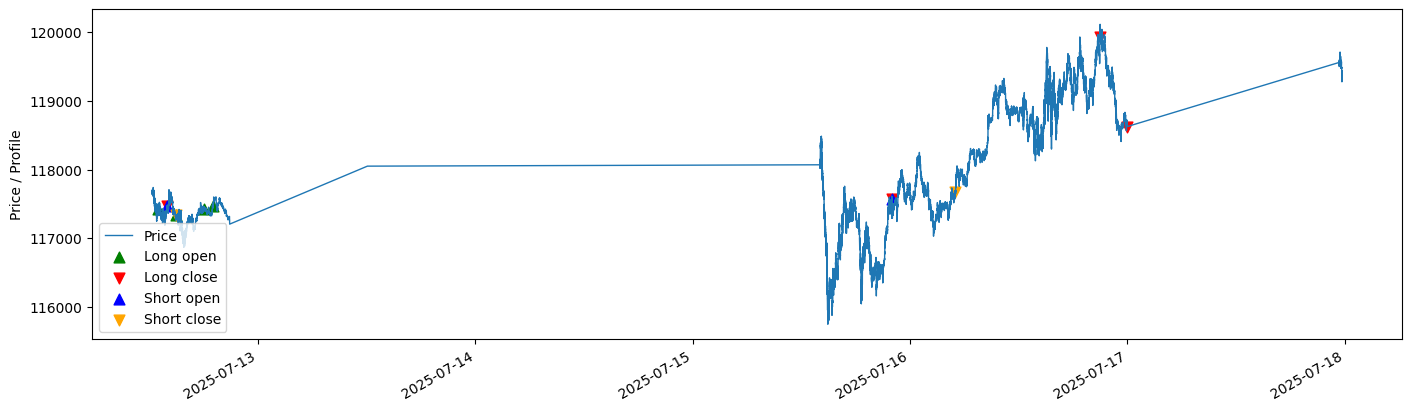

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    figsize=(14, 4),
    constrained_layout=True
)

# Рисуем цену
ax.plot(df['recv_time'], df['price'], label='Price', linewidth=1)

# 1) Разделяем trades на два списка
trades_long  = [t for t in trades if t['direction'] == 'long']
trades_short = [t for t in trades if t['direction'] == 'short']

# 2) Извлекаем отдельно entry/exit времена и цены для каждого направления
long_open_times  = [t['entry_time']  for t in trades_long]
long_open_prices = [t['entry_price'] for t in trades_long]
long_close_times  = [t['exit_time']  for t in trades_long]
long_close_prices = [t['exit_price'] for t in trades_long]

short_open_times  = [t['entry_time']   for t in trades_short]
short_open_prices = [t['entry_price']  for t in trades_short]
short_close_times  = [t['exit_time']   for t in trades_short]
short_close_prices = [t['exit_price']  for t in trades_short]

# 3) Наносим на график
ax.scatter(long_open_times,  long_open_prices,  marker='^', color='g', s=60, label='Long open')
ax.scatter(long_close_times, long_close_prices, marker='v', color='r', s=60, label='Long close')

ax.scatter(short_open_times,  short_open_prices,  marker='^', color='b',      s=60, label='Short open')
ax.scatter(short_close_times, short_close_prices, marker='v', color='orange', s=60, label='Short close')

ax.set_ylabel("Price / Profile")
ax.legend(loc='lower left')
ax.grid(False)

fig.autofmt_xdate()
plt.show()

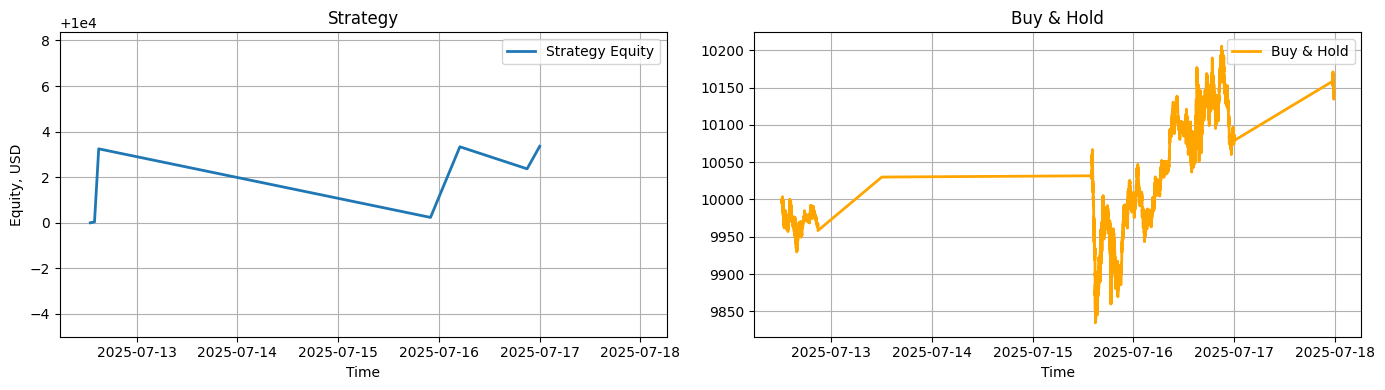

Strategy returns:
0.00033361386818760364 %, Balance: 10003.336138681876
Buy&Hold returns:
0.014568792110249341 %, Balance: 10145.687921102493


C:\Users\382he\AppData\Local\Temp\ipykernel_10744\2589324661.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Buy&Hold returns:\n{(bh_equity[-1]-bh_equity[0])/10000} %, Balance: {bh_equity[-1]}')


In [68]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14,4),sharex=True, sharey=False)

# Стратегия
pts = sorted(zip(times, equity), key=lambda x: x[0])
times_sorted, equity_sorted = zip(*pts)

ax0.plot(times_sorted, equity_sorted, label='Strategy Equity', linewidth=2)
ax0.set_title("Strategy")
ax0.set_xlabel("Time")
ax0.set_ylabel("Equity, USD")
ax0.legend()
ax0.grid(True)
# Сузим диапазон Y, чтобы мелкие изменения было видно:
y_min = min(equity)*0.9995
y_max = max(equity)*1.0005
ax0.set_ylim(y_min, y_max)

# Buy & Hold
ax1.plot(bh_equity.index, bh_equity.values, 
         label='Buy & Hold', color='orange', linewidth=2)
ax1.set_title("Buy & Hold")
ax1.set_xlabel("Time")
ax1.legend()
ax1.grid(True)


plt.tight_layout()
plt.show()

print(f'Strategy returns:\n{(equity[-1]-equity[0])/10000} %, Balance: {equity[-1]}')
print(f'Buy&Hold returns:\n{(bh_equity[-1]-bh_equity[0])/10000} %, Balance: {bh_equity[-1]}')